In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numba
import numba.typed

from pathlib import Path
from tqdm import trange, tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import pysam
import pprint
import pickle
import joblib
import polars as pl

# This is needed before pybedtools to make sure bedtools is imported on sanger JupyterHub 
os.environ["PATH"] += ":" + os.path.join(sys.prefix, "bin")
import pybedtools

pd.set_option('display.max_rows', 1000)


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference

In [4]:
aut_chrom_names = [f"chr{i}" for i in list(range(1, 23))]
chrom_names = aut_chrom_names + ["chrX", "chrY"]

# Read the classified events

In [5]:
# Samples to do
sample_ids = [
    "PD50477f",
    # "PD50508bf", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD50519d",
    # "PD47269d", -- don't use, not there
    "PD50508f",
    # "PD50511e", -- don't use, likely mixture
    "PD50523b",
    # "PD48473b", -- don't use, not there
    "PD50521b",
    "PD50508b",
    # "PD50521be", -- ignore; merged two sampling dates just for phasing, but should be analyzed separately
    "PD46180c",
    # "PD50502f", -- don't use, likely mixture
    "PD50521e",
    # "PD50511e_SS",  --- don't use
    "PD50489e",
]

cls_df = pl.concat([
    pl.read_parquet(
        str(Path("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/01.read_alignment/01.ccs/04.hifiasm/02.hifiasm_0.19.5-r592/02.chromosome_length_scaffolds")
            / f"{focal_sample_id}" / "reads" / f"{chrom}_RagTag.certainty_0.95.classified_reads.parquet")
    ) \
    for focal_sample_id in sample_ids
    for chrom in aut_chrom_names
])

In [6]:
trusty_cls_df = (cls_df
    .filter(~pl.col("has_common_transition"))
    .filter(pl.col("min_coverage_between_transitions_hap1") >= 3)
    .filter(pl.col("min_coverage_between_transitions_hap2") >= 3)
)

# Utils

In [7]:
def hist_transitions(df, upto=2):
    return np.histogram(df["n_transitions"], bins=np.arange(upto+2), density=True)[0]

# Functions to get call set for a single sample

In [17]:
def generate_call_set(focal_sample_ids, take_every=1, bootstrap=False):
    # Create the joint dataframe
    both_df = (
        trusty_cls_df
            .filter(pl.col("sample_id").is_in(focal_sample_ids))
            .select(["read_length", "snp_positions_on_read", "idx_transitions", "sample_id", "read_name"])
            .with_columns(weight = 1)        
    )    
    
    # Bootstrap if needed
    if bootstrap:
        both_df = both_df.sample(n = len(both_df), with_replacement = True)
    
    # Add useful fields
    aug_both_df = (both_df
        .with_columns(
            prob_inside = 1 - (pl.col("snp_positions_on_read").list.get(0) + pl.col("read_length") - pl.col("snp_positions_on_read").list.get(-1)) / pl.col("read_length"),
            n_transitions = pl.col("idx_transitions").list.len(),
        )
        .with_columns(
            rounded_prob_inside = pl.col("prob_inside") // 0.1 * 0.1,
        )
    )
    
    # Just take GC-s
    aug_both_df = aug_both_df.filter(pl.col("n_transitions") == 2)
    
    return aug_both_df


In [55]:
def extract_exponential_samples(
    idx_transitions,
    snp_positions_on_read,
):
    dists = []
    is_continued = []
    
    # Which SNP indices are different?
    diff_snp_indices = np.arange(idx_transitions[0]+1, idx_transitions[1]+1)
      
    for i in diff_snp_indices:
        # Try left
        dists.append(snp_positions_on_read[i] - snp_positions_on_read[i-1])
        is_continued.append(i-1 in diff_snp_indices)
        
        # Try right
        dists.append(snp_positions_on_read[i+1] - snp_positions_on_read[i])
        is_continued.append(i+1 in diff_snp_indices)
    
    return dists, is_continued
    

def exponential_likelihood(
    all_dists,
    all_is_continued,
    mean_tract_length,
):
    lmb = 1/mean_tract_length
    prob_conv = np.exp(-lmb * all_dists)
    all_is_continued_bool = np.array(all_is_continued).astype(int)
    
    LL = (all_is_continued_bool * np.log(prob_conv) + (1-all_is_continued_bool) * np.log(1-prob_conv)).sum()
    
    return LL

def get_best_tract_length(df):
    lsts = [extract_exponential_samples(*xx) \
        for xx in zip(df["idx_transitions"].to_numpy(), df["snp_positions_on_read"].to_numpy())]
    all_dists, all_is_continued = zip(*lsts)

    all_dists = np.concatenate(all_dists)
    all_is_continued = np.concatenate(all_is_continued)
    
    tts = np.arange(1, 1000, 0.1)
    lls = [exponential_likelihood(
        all_dists,
        all_is_continued,
        tt
    ) for tt in tts]
    
    return tts, lls

/tmp/ipykernel_4524/1674801664.py:32: RuntimeWarning: divide by zero encountered in log
  LL = (all_is_continued_bool * np.log(prob_conv) + (1-all_is_continued_bool) * np.log(1-prob_conv)).sum()
/tmp/ipykernel_4524/1674801664.py:32: RuntimeWarning: invalid value encountered in multiply
  LL = (all_is_continued_bool * np.log(prob_conv) + (1-all_is_continued_bool) * np.log(1-prob_conv)).sum()


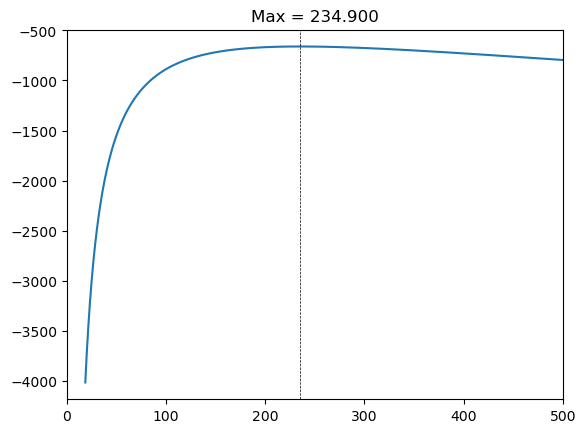

In [82]:
df = generate_call_set(sample_ids, 100, False)
df = df.sample(n=len(df), with_replacement=True)
tts, lls = get_best_tract_length(df)
plt.plot(tts, lls);
plt.xlim(0, 500);
max_tt = tts[np.nanargmax(lls)]
plt.title(f"Max = {max_tt:1.3f}");
plt.axvline(max_tt, color="black", ls="--", lw=0.5);